In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import re
import wandb

from data import WordSequenceDataset
from model import EncoderOnlyNextTokenPredictor

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\\s]", "", text)  
    return text

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 100
learning_rate = 1e-3
window_size = 3
max_vocab_size = 50

In [4]:
dataset = WordSequenceDataset("data/simple_corpus.txt", window_size=window_size, max_vocab_size=max_vocab_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[DEBUG] final samples : 1716


In [5]:
print("# of vocabs", dataset.vocab_size)
print("Top 20 vocabs:", list(dataset.token2idx.keys())[2:22])

# of vocabs 50
Top 20 vocabs: ['not', 'do', 'they', 'you', 'he', 'she', 'i', 'we', 'want', 'to', 'hate', 'prefer', 'eat', 'a', 'like', 'drink', 'need', 'love', 'sushi', 'tea']


### Dataset & Dataloader

### Model setup

In [6]:
model = EncoderOnlyNextTokenPredictor(vocab_size=dataset.vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Loop

In [7]:
wandb.finish()

In [8]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oizhq2062 (oizhq2062-yonsei-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
wandb.init(project="embedding-visualization", config={
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "window_size": window_size,
    "max_vocab_size": max_vocab_size
})

In [10]:
wandb.watch(model.token_embedding, log="all", log_freq=10)

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        grad_norm = torch.norm(model.token_embedding.embedding.weight.grad)
        wandb.log({"embedding_grad_norm": grad_norm.item()})

        embedding_weights = model.token_embedding.embedding.weight.detach().cpu().numpy()
        wandb.log({
            "embedding_weights_step": wandb.Histogram(embedding_weights.flatten())
        })

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    wandb.log({"loss": avg_loss, "epoch": epoch})


Epoch 1: Loss = 2.8997
Epoch 2: Loss = 1.8689
Epoch 3: Loss = 1.5835
Epoch 4: Loss = 1.5436
Epoch 5: Loss = 1.5211
Epoch 6: Loss = 1.5057
Epoch 7: Loss = 1.4940
Epoch 8: Loss = 1.4987
Epoch 9: Loss = 1.4999
Epoch 10: Loss = 1.4891
Epoch 11: Loss = 1.4809
Epoch 12: Loss = 1.4787
Epoch 13: Loss = 1.4824
Epoch 14: Loss = 1.4722
Epoch 15: Loss = 1.4805
Epoch 16: Loss = 1.4721
Epoch 17: Loss = 1.4723
Epoch 18: Loss = 1.4724
Epoch 19: Loss = 1.4740
Epoch 20: Loss = 1.4756
Epoch 21: Loss = 1.4742
Epoch 22: Loss = 1.4704
Epoch 23: Loss = 1.4695
Epoch 24: Loss = 1.4685
Epoch 25: Loss = 1.4694
Epoch 26: Loss = 1.4713
Epoch 27: Loss = 1.4744
Epoch 28: Loss = 1.4682
Epoch 29: Loss = 1.4682
Epoch 30: Loss = 1.4727
Epoch 31: Loss = 1.4680
Epoch 32: Loss = 1.4681
Epoch 33: Loss = 1.4658
Epoch 34: Loss = 1.4632
Epoch 35: Loss = 1.4631
Epoch 36: Loss = 1.4619
Epoch 37: Loss = 1.4675
Epoch 38: Loss = 1.4641
Epoch 39: Loss = 1.4588
Epoch 40: Loss = 1.4695
Epoch 41: Loss = 1.4627
Epoch 42: Loss = 1.4649
E

### Non-contextual visualization

In [11]:
def visualize_token_embeddings(model, idx2token):
    emb = model.token_embedding.embedding.weight.detach().cpu().numpy()
    reduced = TSNE(n_components=2, perplexity=5).fit_transform(emb)

    plt.figure(figsize=(8, 6))
    for i, label in idx2token.items():
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=12)
    plt.title("Non-Contextual Token Embedding")
    plt.grid(True)
    plt.show()

/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


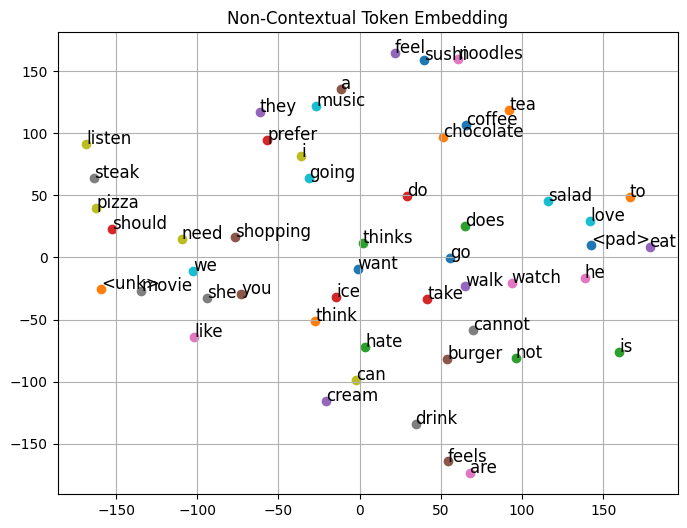

In [12]:
visualize_token_embeddings(model, dataset.idx2token)

### Contextual Embedding

In [13]:
def extract_contextual_embeddings(model, sentence, token2idx):
    model.eval()
    tokens = sentence.split()
    idxs = [token2idx.get(tok, 1) for tok in tokens]  # 1 is <unk>
    x = torch.tensor([idxs]).to(device)

    with torch.no_grad():
        tok_emb = model.token_embedding(x)
        pos_emb = model.pos_embedding(x)
        x = tok_emb + pos_emb
        for layer in model.encoder_layers:
            x = layer(x)
        x = model.norm(x)
        return x.squeeze(0).cpu().numpy(), tokens

def visualize_contextual_embeddings(model, token2idx, sentences):
    vectors = []
    labels = []
    for sentence in sentences:
        vecs, toks = extract_contextual_embeddings(model, sentence, token2idx)
        vectors.extend(vecs)
        labels.extend([f"{tok} ({sentence})" for tok in toks])

    reduced = TSNE(n_components=2, perplexity=3).fit_transform(np.array(vectors))

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=10)
    plt.title("Contextual Embeddings by Sentence")
    plt.grid(True)
    plt.show()


/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


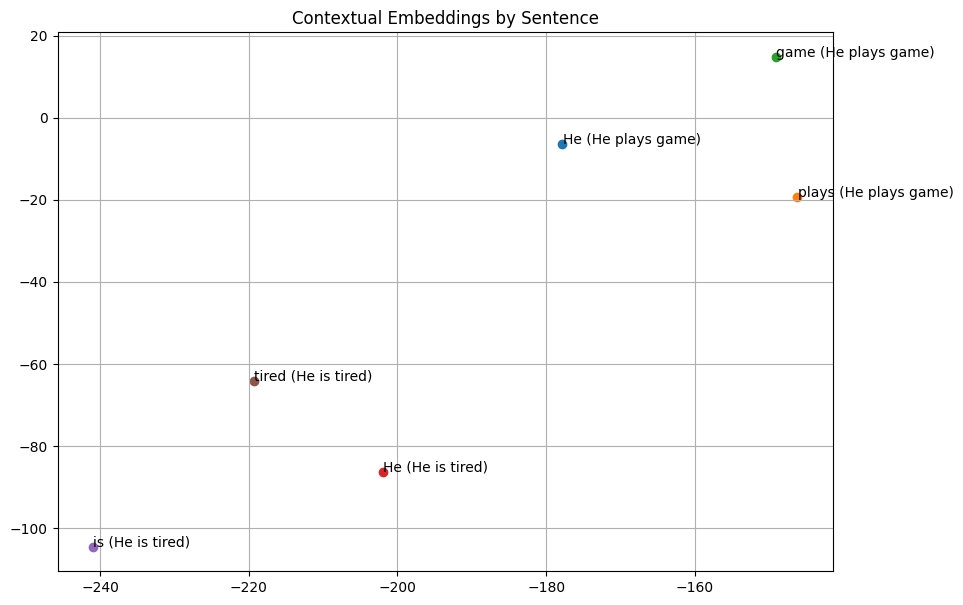

In [14]:
sentences = ["He plays game", "He is tired"]
visualize_contextual_embeddings(model, dataset.token2idx, sentences)